In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from os import path

In [2]:
directory = '/home/users/swmclau2/scratch/UatuLightconeTraining/Box000/'

In [3]:
fname = path.join(directory, 'proj_bias_hist_idx_000_box_000.npy')

In [4]:
im_list = np.load(fname)
print im_list.shape

(2025, 16, 16, 1)


In [5]:
fname2 = path.join(directory, 'full_proj_box_000.npy') #'full_bias_hist_idx_000_box_000.npy'

In [6]:
particle_box = np.load(fname2)

In [7]:
particle_box.shape

(720, 720, 1)

In [8]:
np.max(particle_box), np.min(particle_box)

(9936.0, 0.0)

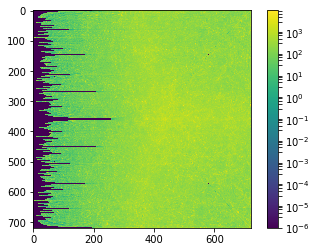

In [9]:
img = plt.imshow(particle_box[:,:,0] - particle_box.min() + 1e-6, norm = LogNorm(vmin = 1e-6, vmax = particle_box.max()-particle_box.min()))
plt.colorbar(img)

In [10]:
box_3d_fname = path.join(directory, 'full_particle_hist_000.npy')
box_3d = np.load(box_3d_fname)

In [11]:
box_3d.shape

(256, 256, 256)

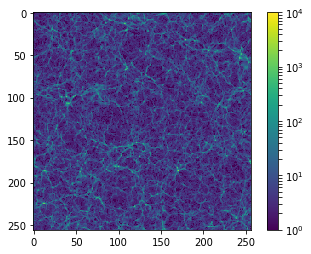

In [12]:
img = plt.imshow( box_3d[:,:, 2]+1, norm = LogNorm(vmin = 1, vmax = 10000) )
plt.colorbar(img)
plt.show()

In [13]:
from uatu.simulations import get_astropy_cosmo, convert_box_to_proj_density#, ra_dec_z#convert_box_to_proj_density
from itertools import product, izip

In [14]:
def ra_dec_z(x, cosmo=None):
    if len(x.shape) == 1:
        x = np.array([x])

    # calculate the observed redshift
    if cosmo is None:
        cosmo = cosmology.FlatLambdaCDM(H0=0.7, Om0=0.3)

    # remove h scaling from position so we can use the cosmo object
    x = x/cosmo.h

    # compute comoving distance from observer
    r = np.sqrt(x[:, 0]**2+x[:, 1]**2+x[:, 2]**2)

    # compute cosmological redshift and add contribution from perculiar velocity
    yy = np.arange(0, 1.0, 0.001)
    xx = cosmo.comoving_distance(yy).value
    f = interp1d(xx, yy, kind='cubic')
    redshift = f(r)

    # calculate spherical coordinates
    theta = np.arccos(x[:, 2]/r)
    phi = np.arctan2(x[:, 1], x[:, 0])
    ra = phi
    dec = theta - np.pi/2.0

    return ra, dec, redshift

In [15]:
import pandas as pd
from scipy.interpolate import interp1d

In [16]:
import healpy

In [17]:
4096*2

8192

In [26]:
def convert_box_to_proj_density(directory, boxno,box, Lbox = 512.0, nside = 4096, pixels_per_side = 8, n_z_bins = 4):
    # ang size image: size of each sub image in degrees
    # pixels_per_side: number of pixels per side in the sub images
    
    reader = pd.read_csv(path.join(directory, 'uatu_lightcone.0'), delim_whitespace = True, chunksize = 50000)

    cosmo = get_astropy_cosmo(directory, boxno)
    #establish min/max bounds

    test_coords = np.c_[np.array([0.0, 0.0, 0.0, 0.0, 512.0, 512.0, 512.0, 512.0]),\
                        np.array([0.0, 0.0, 512.0, 512.0, 0.0, 0.0, 512.0, 512.0]),\
                        np.array([0.0, 512.0, 0.0, 512.0, 0.0, 512.0, 0.0, 512.0])]

    ra,dec,z = ra_dec_z(test_coords, cosmo=cosmo)
    ra, dec = np.degrees(ra), np.degrees(dec)
    min_ra, max_ra = np.nanmin(ra), np.nanmax(ra)
    min_dec, max_dec = np.nanmin(dec), np.nanmax(dec)
    min_z, max_z = 0.0, np.nanmax(z)

    z_bin_size = max_z/n_z_bins
    
    npix = healpy.nside2npix(nside)
    hp_pixelization = np.zeros((npix,n_z_bins))

    
    for i, chunk in enumerate(reader):
        arr = chunk.values[:, :3]
        #x,y,z = arr[:,0].astype(float), arr[:,1].astype(float), arr[:,2].astype(float)
        coords = arr.astype(float)
        _, _, z = ra_dec_z(coords, cosmo=cosmo)
        pix_idxs = healpy.vec2pix(nside, coords[:,0], coords[:,1], coords[:,2]) #nest?

        z_idx = np.floor_divide(z, z_bin_size).astype(int)

        for pi, zi, density  in izip(pix_idxs, z_idx, np.nditer(box)):
            hp_pixelization[pi,  zi] += density #would like to avoid this for loop, hopefully numba helps

        
    return hp_pixelization
    # God has left this place
    # convert the histogram in a list of sub-voxels which will be hte input to the training set.
    x = np.array(np.split(proj_density, (max_ra - min_ra)/ang_size_image))
    pixel_list = np.vstack(np.split(x, (max_dec-min_dec)/ang_size_image, axis = 2))

    return pixel_list, proj_density
    #np.save(path.join(directory, 'part

In [ ]:
hp_pixelization = convert_box_to_proj_density(directory, 0, box = box_3d,\
                                    nside = 4096, pixels_per_side = 32,  n_z_bins = 4)

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


In [ ]:
map_rot = healpy.cartview(hp_pixelization[:,0]+1,lonra = [0, 90], latra = [0, 90],\
                          rot = [0,0, 0], return_projected_map=True, norm = 'log', cbar = False)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ValueError: values must all be positive

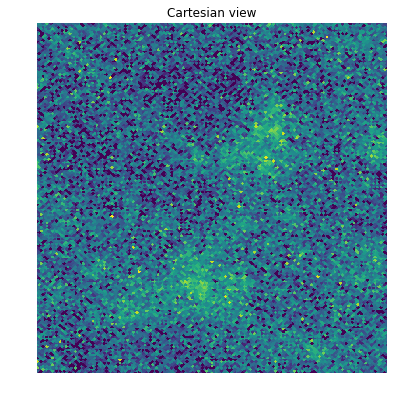

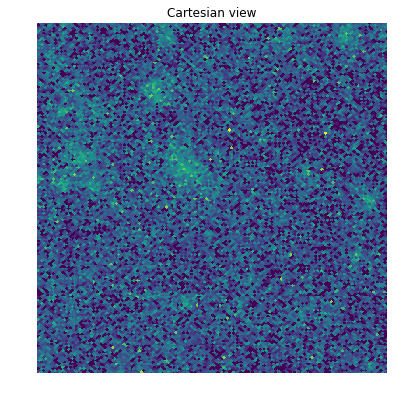

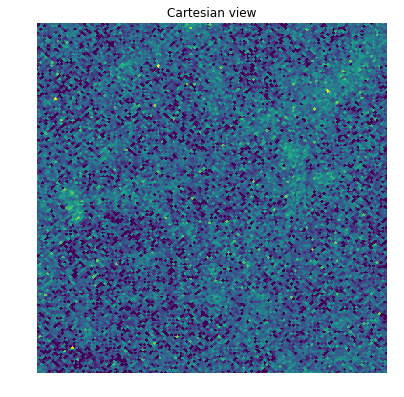

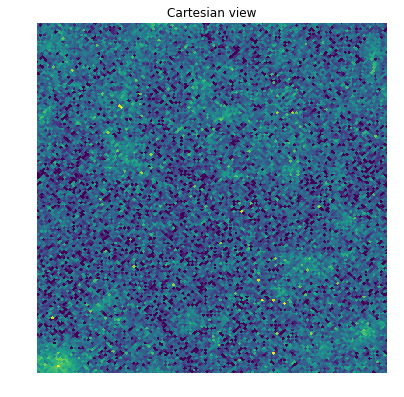

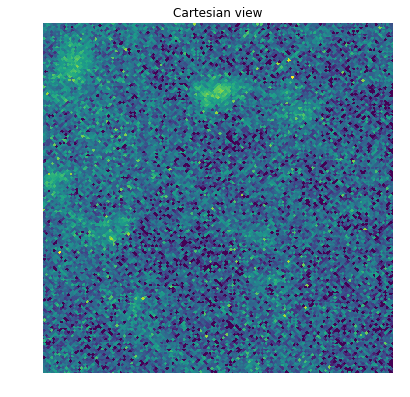

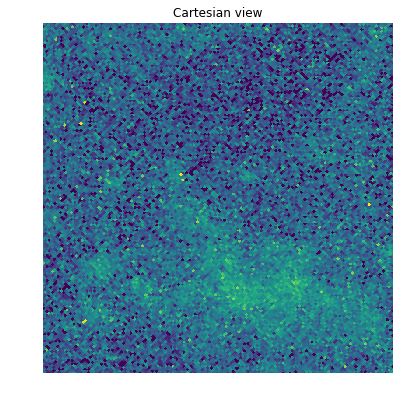

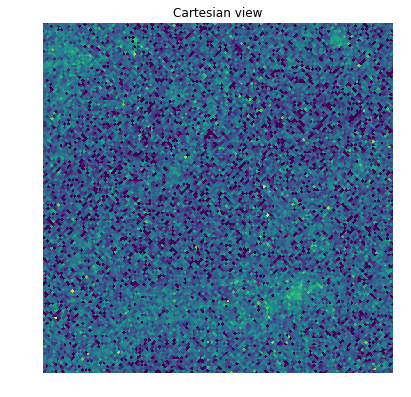

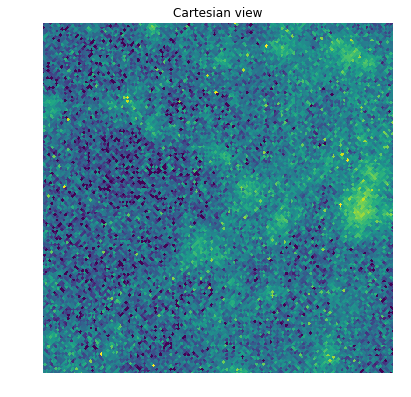

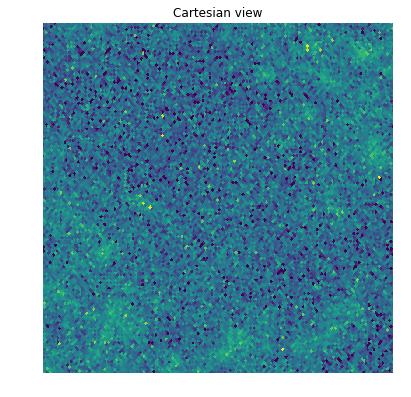

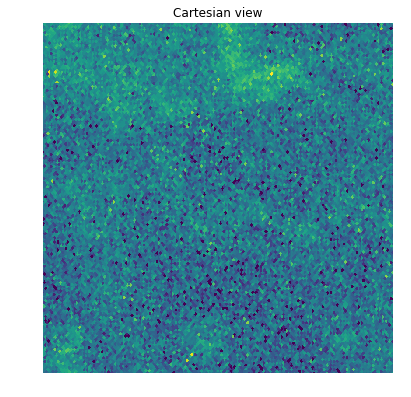

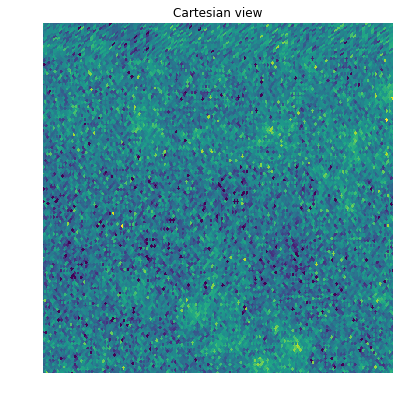

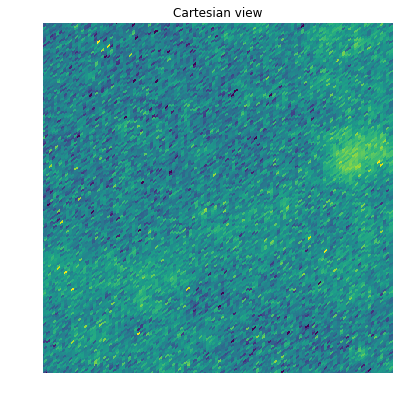

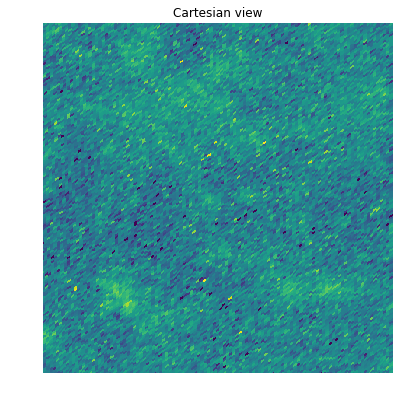

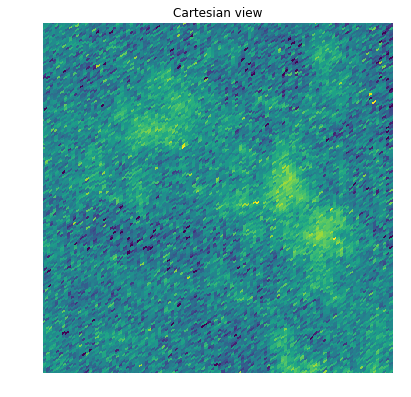

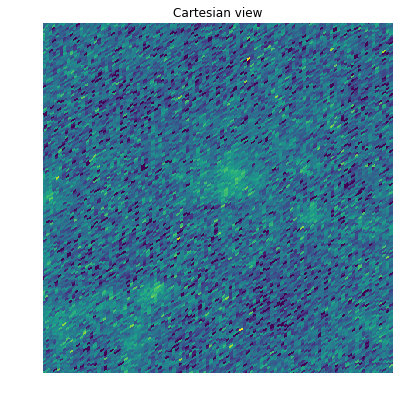

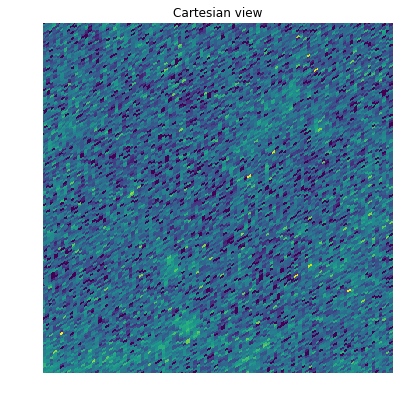

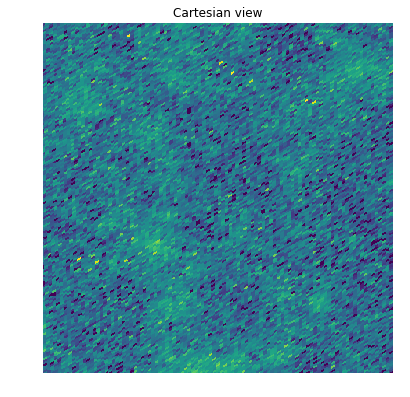

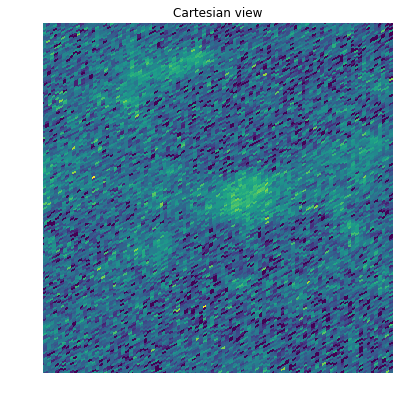

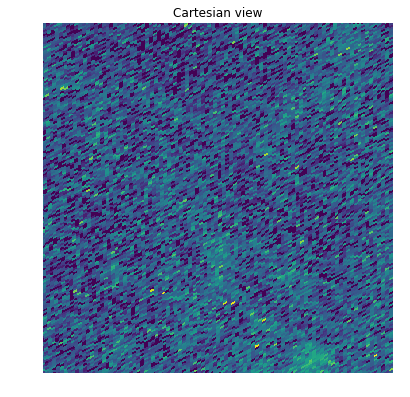

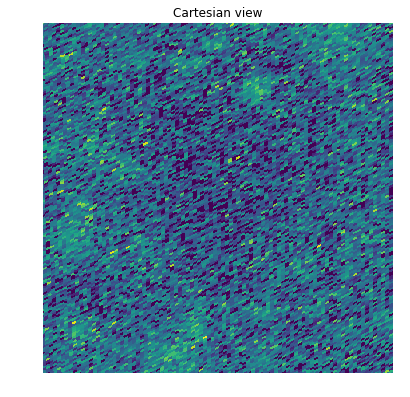

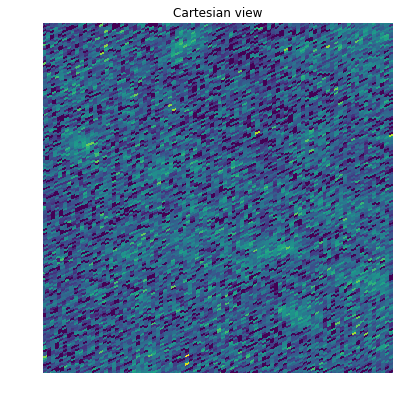

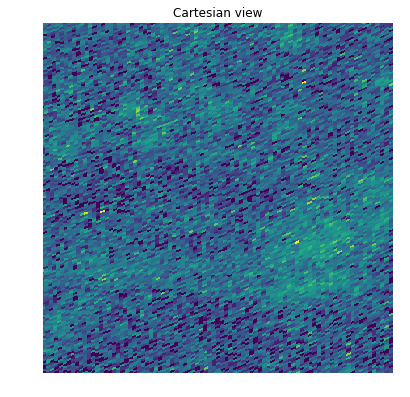

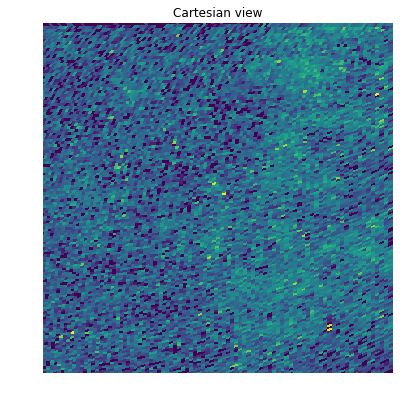

ValueError: values must all be positive

In [25]:
size = 2

for a in xrange(0, 90, size):
    for b in xrange(0, 90, size):
        map_rot = healpy.cartview(hp_pixelization[:,0]+1,lonra = [a, a+size],latra = [b, b+size],\
                          rot = [a,b, 0], return_projected_map=True, norm = 'log', cbar = False)

In [26]:
ra, dec

(array([ 9., 27., 45., 63.]),
 array([75.34073424, 75.34073424, 75.34073424, 75.34073424]))

In [27]:
proj_box_list , full_proj_box = convert_box_to_proj_density(directory, 0, box = box_3d,\
                                                            ang_size_image = 2, pixels_per_side = 32,  n_z_bins = 1)

TypeError: convert_box_to_proj_density() got an unexpected keyword argument 'ang_size_image'

In [ ]:
plt.scatter(ra, dec)

In [ ]:
plt.hist(ra)

In [ ]:
plt.hist(dec)

In [ ]:
cosmo = get_astropy_cosmo(directory, 0)

In [ ]:
test_coords = np.c_[np.array([0.0, 0.0,   0.0,   0.0,   512.0, 512.0, 512.0, 512.0]),\
                    np.array([0.0, 0.0,   512.0, 512.0, 0.0,   0.0,   512.0, 512.0]),\
                    np.array([0.0, 512.0, 0.0,   512.0, 0.0,   512.0, 0.0,   512.0])]

ra,dec,z = ra_dec_z(test_coords, cosmo=cosmo)
print np.degrees(ra), np.degrees(dec), z

In [ ]:
ra,dec,z = ra_dec_z(np.array([512.0, 512.0, 512.0]), cosmo=cosmo)
print np.degrees(ra), np.degrees(dec), z

In [ ]:
full_proj_box.shape, np.max(full_proj_box)

In [ ]:
img = plt.imshow( full_proj_box[:,:, 0]+1, norm = LogNorm(vmin = 1, vmax = 10000) )
plt.colorbar(img)
plt.show()